In [12]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from flask import jsonify

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, extract

In [2]:
# Connect to database and reflect to Base object
engine = create_engine("sqlite:///hawaii.sqlite")

Base = automap_base()
Base.prepare(engine, reflect=True)

In [3]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [4]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [5]:
# Create session from Python to the DB
session = Session(engine)

In [6]:
# Find date of last data point in database:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date

'2017-08-23'

<AxesSubplot:xlabel='date'>

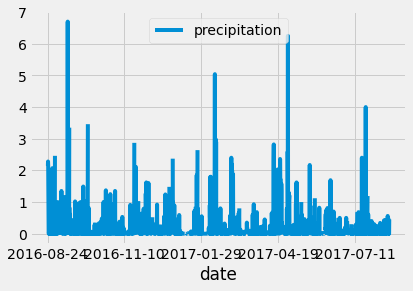

In [7]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Calculate the date one year from the last date in data set
prev_year = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()

In [8]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [9]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9,)]

In [17]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
hist_results = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= prev_year).all()

In [26]:
hist_df = pd.DataFrame(hist_results, columns=['tobs'])
hist_df

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


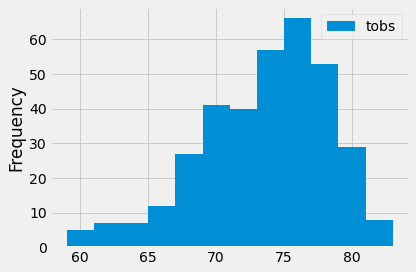

In [29]:
hist_df.plot.hist(bins=12)
plt.tight_layout()

In [ ]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start=None, end=None):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]

    if not end:
        results = session.query(*sel).\
            filter(Measurement.date >= start).all()
        temps = list(np.ravel(results))
        return jsonify(temps)

    results = session.query(*sel).\
        filter(Measurement.date >= start).\
        filter(Measurement.date <= end).all()
    temps = list(np.ravel(results))
    return jsonify(temps)